# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [71]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Developing Ventilation "Base Case"
To illustrate the effectiveness of our methods to determine occupancy and then calculate ventilation rates, we can create a "base case" set of ventilation rates that are calculated in a more "traditional" manner. By traditional, I am thinking:
* steady-state estimates only
* only consider weekday measurements during an early morning period i.e. 1:00 - 4:00 am.

We might also consider splitting participants into multiple sub-participants and calculating ventilation rates from only a few days which is also a more traditional approach (large number of participants, few ventilation rates per participant). I am not as big a fan of this method since, in the end, we would generater similar results to what we calculated earlier.

## Package Import

In [72]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import ventilation
from src.analysis import occupancy_detection

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.neural_network import MLPClassifier

---

<a id="toc"></a>

# Table of Contents

1. [Data Notes](#data)
2. [Analysis Notes](#analysis)
    1. [Steady-State Estimation](#steady_state)
    2. [Dynamic Estimation](#dynamic)
    3. [Sensitivity Analysis](#sa)
4. [SA: Steady-State](#ss_sa)
5. [SA: Build-Up](#buildup_sa)
6. [SA: Decay](#decay_sa)

---

<a id="data"></a>

# Notes on Data Used
The necesary data are imported when insantiating a `calculate` object. 

---

<a id="analysis"></a>

# Notes on Analysis
We start with a short description on the estimation methods -- for more information on the individual parameters within each method, see the primary notebook [here](https://github.com/intelligent-environments-lab/utx000/blob/master/notebooks/4.1.4-hef-beacon-ventilation_estimation.ipynb).

<a id="steady_state"></a>

[Back to ToC](#toc)
## Ventilation based on constant CO2 concentration
We can estimate the ventilation rate of the participants' bedrooms based on a constant CO2 concentration:

$$
\lambda = \frac{E}{V \left(C - pC_0\right)}
$$

In our case we have to make quite a few assumptions:
- $E$: Emission rate of CO2 can be estimated for humans to be approximately $30 g/hr$. We can further refine this value by considering the height, weight, sex, and activity level of the participant - all information that we have access to. 
- $V$: Arguably the most difficult value to track down and the one that could affect the answer the most. We can assume a volume of each of the participants bedrooms, but there is the possiblility of refining this value by cross-referencing the participants' addresses with any known apartment complexes. From there, we can estimate the floor plan based on the number of roommates.
- $p$: Penetration factor of background CO2 from into the space - we can safely assume this to be 1.
- $C_0$: Background CO2 concentration. While 400 - 450 ppm is the typical assumption, using this value seems to result in very low ventilation rates.

<a id="dynamic"></a>

[Back to Top](#inspecting)

---

# Base Case: Steady-State Estimates
In these cells we estimate the steady-state ventilation rates from weekday carbon dioxide measurements made during 1:00 - 4:00.

In [29]:
base = ventilation.base_case(data_dir="../data")

Looks like we can still use most of the source code that was originally in place, but we just use a different subset of data. So we need to simply create a new function that finds the specified periods for each participant and append them to a dataframe.

Since the `ventilaion_ss()` method in the source code relies on the nightly IAQ conditions, I created a subclass to the `steady_state` class which overwrites this method.

In [55]:
base_data = base.get_base_data()
estimates_base = base.ventilation_ss(base_data,base.info,constant_c0=False,c0_percentile=0,
                                      min_co2_threshold=None,co2_threshold_percentile=50,plot=False)
estimates_base["method"] = "Base Case"
estimates_base.head()

,start,end,beiwe,beacon,co2_mean,co2_delta,t_mean,t_delta,e,c0,v,ach,method
0,2020-06-08 02:30:00,2020-06-08 03:30:00,vr9j5rry,25.0,662.495040,0.135675,23.320504,-0.003280,0.003250,460.649886,1080.0,1.899589,Base Case
1,2020-06-09 01:26:00,2020-06-09 02:38:00,vr9j5rry,25.0,627.539293,-0.367786,24.501485,-0.005271,0.003263,460.649886,1080.0,2.306623,Base Case
2,2020-06-09 01:56:00,2020-06-09 03:56:00,xlw5ntd5,10.0,1172.317192,0.074492,29.664156,-0.011984,0.002675,569.124672,1188.0,0.475572,Base Case
3,2020-06-12 01:00:00,2020-06-12 03:44:00,idbkjh8u,30.0,1154.529677,0.429204,19.199683,-0.016683,0.003168,236.604189,1080.0,0.407224,Base Case
4,2020-06-12 01:42:00,2020-06-12 03:56:00,kyj367pi,1.0,632.301088,0.203435,16.455691,0.000000,0.002526,486.795966,1080.0,2.048494,Base Case


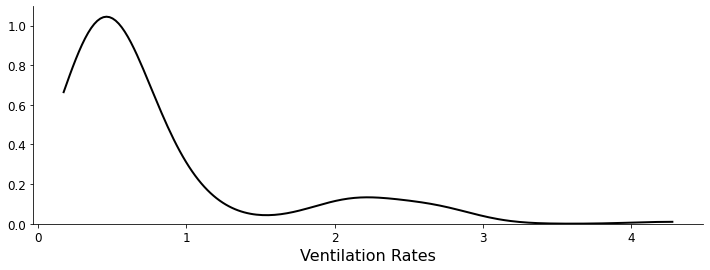

count    148.000000
mean       0.795382
std        0.732978
min        0.173144
25%        0.380005
50%        0.492237
75%        0.790432
max        4.278387
Name: ach, dtype: float64


In [56]:
base.summarize_estimates(estimates_base)

### Saving

In [74]:
estimates_base.to_csv("../data/processed/beacon-ventilation_estimates-base_case_ss-ux_s20.csv",index=False)

## Comparing to Other Steady-State Estimates

### Information Fusion

In [57]:
estimates_if = pd.read_csv("../data/processed/beacon-ventilation_estimates-ss-ux_s20.csv")
estimates_if["method"] = "Data Fusion"
estimates_if.head()

,start,end,beiwe,beacon,co2_mean,co2_delta,t_mean,t_delta,e,c0,v,ach,method
0,2020-05-31 23:48:00,2020-06-01 07:47:00,zdpffrox,7.0,1781.098559,-0.034184,23.409050,-0.008173,0.003743,679.678970,1365.0,0.317212,Data Fusion
1,2020-06-02 23:48:00,2020-06-03 08:11:00,zdpffrox,7.0,1713.431691,-0.054139,25.024248,-0.003633,0.003763,679.678970,1365.0,0.339898,Data Fusion
2,2020-06-04 23:25:00,2020-06-05 07:18:00,vr9j5rry,25.0,661.261969,0.255968,23.294573,-0.003213,0.003250,460.649886,1080.0,1.911098,Data Fusion
3,2020-06-06 00:28:00,2020-06-06 07:19:00,vr9j5rry,25.0,674.597049,0.446399,23.272756,-0.004673,0.003249,460.649886,1080.0,1.791849,Data Fusion
4,2020-06-07 00:46:00,2020-06-07 08:46:00,zdpffrox,7.0,1645.942662,-0.813084,23.867991,-0.008070,0.003749,679.678970,1365.0,0.362142,Data Fusion


### Model-Detected

In [67]:
estimates_model = pd.read_csv("../data/processed/beacon-ventilation_estimates-occ-ux_s20.csv")
estimates_model = estimates_model[estimates_model["method"] == 90]
estimates_model["method"] = estimates_model['method'].astype(str)
estimates_model.head()

,start,end,beiwe,beacon,co2_mean,co2_delta,t_mean,t_delta,e,c0,v,ach,method
742,2020-06-10 04:40:00,2020-06-10 11:10:00,kyj367pi,1.0,636.937418,-1.787027,17.487162,-0.033181,0.002535,486.795966,1080.0,2.004302,90
743,2020-06-11 02:00:00,2020-06-11 03:30:00,zdpffrox,7.0,1607.359748,6.918521,22.330322,-0.031778,0.003729,679.678970,1365.0,0.375250,90
744,2020-06-11 04:50:00,2020-06-11 06:10:00,kyj367pi,1.0,676.847147,-2.177107,16.328666,-0.195490,0.002525,486.795966,1080.0,1.567659,90
745,2020-06-11 07:20:00,2020-06-11 10:00:00,zdpffrox,7.0,1764.858929,1.558950,22.093372,-0.021630,0.003726,679.678970,1365.0,0.320530,90
746,2020-06-12 21:20:00,2020-06-13 02:20:00,kyj367pi,1.0,633.701219,0.788909,17.361058,-0.000215,0.002534,486.795966,1080.0,2.035316,90


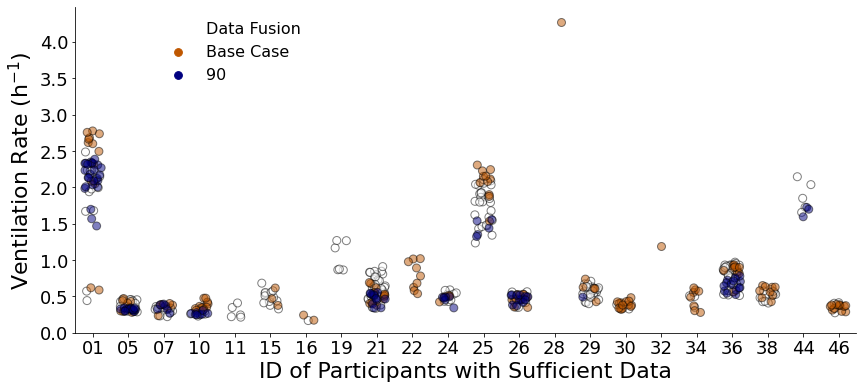

In [73]:
estimates = pd.concat([estimates_base,estimates_if,estimates_model])
ventilation.plot_strip(estimates,save=False,annot="-ss_only")

---